# This Notebook is a demonstrator for results on the first proof-of-concept (POC1) biodiversity data asset, which focuses on the taxonomic composition found in a given environmental sample. In a nutshell, we assess relative abundances across numerous plankton taxonomic groups from metagenomics (MTG) datasets collected in the context of the TARA Ocean expedition.  

Results shown here were obtained via the Motus profiling tool (see GH repo [here](https://github.com/motu-tool/mOTUs)) run. Importantly, Motus is called via a tool known as [read_counter](https://github.com/AlessioMilanese/read_counter), which is a wrapper to run Motus using a customized DB.  

See Notebook: `../Custom_DB_MTG/CustomDB_MTG_Taxa_Profiling_v1.0.ipynb` for a detailed description on DB customization.  

The pipeline was run on several metagenomes, as described in `Run_MTG_taxa_profiler.ipynb`


In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns
import colorsys
from matplotlib.collections import PatchCollection

import Bio.SeqIO as bioseqio
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
#from Bio.Alphabet import IUPAC
from Bio import Entrez

from ete3 import NCBITaxa
from taxonomy_ranks import TaxonomyRanks

from subprocess import Popen, call, STDOUT, PIPE
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib
import json
import glob
import re
import gzip
import sys
import csv
import time
import io
import re
import pathlib
from collections import OrderedDict
import configparser

import pickle
import bz2 

from IPython.display import Image
from itertools import combinations
import itertools

In [7]:
pd.set_option('mode.chained_assignment', None)
matplotlib.rcParams['savefig.dpi'] = 1000
matplotlib.rcParams['figure.dpi'] = 1000
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper")
sns.set(font='serif')
sns.set_style('ticks')

In [8]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
###Uncomment below if necessary
rendef = "png" #"pdf" 
fig_renderer = pio.renderers[rendef]
fig_renderer.width = 1000
fig_renderer.height = 1000
pio.renderers.default = rendef

Utility functions

In [9]:
def format_tax_lbl(taxid = '94617'):
    """Function to properly format taxonomic labels using NCBI notation"""
    
    tax_lvls_lbls = ['species','genus','family', 'order', 'class', 'phylum', 'superkingdom'][::-1]
    rank_taxon = TaxonomyRanks(taxid)
    rank_taxon.get_lineage_taxids_and_taxanames()
    rank_dict =  list(rank_taxon.lineages.values())[0]
    tax_tree = list(rank_taxon.lineages.values())[0]
    
    #Parsing info on high rank tanks is optional, but can be quite handy when low ranks are unclassified: for higher rank assignment purposes if needed
    tax_ranks_list = [tax_tree[t][0].replace("NA","unclassified") for t in tax_lvls_lbls]
    ncbi_taxIDs_list = [str(tax_tree[t][1]) for t in tax_lvls_lbls]
    return ncbi_taxIDs_list,tax_ranks_list 

def parse_lineage(lineage_str):
    '''Function to correctly parse lineage using NCBI tax ID'''
    return (";".join(format_tax_lbl(lineage_str.split(';')[-1].replace('_', ' '))[-1])).replace(" ","_")

### Taxonomic profiling results    
The following is a simple visualiztion illustrating the relative abundances across a bunch of plankton taxonomic groups (down to the species level) that we obtained from profiling a given TARA Ocean sample (ID: [ERR1719507](https://www.ebi.ac.uk/ena/browser/view/ERR1719507)) collected in the North Atlantic Ocean (offshore Cadiz, Spain, [Location 36.5533 N 6.5669 W](https://www.google.com/maps/place/36%C2%B033'11.9%22N+6%C2%B034'00.8%22W/@36.5534368,-6.5668384,17z/data=!4m5!3m4!1s0x0:0x9aa20881883fdb5f!8m2!3d36.5533!4d-6.5669)), on date/time=2009-09-15T18:00, using a PUMP (High Volume Peristaltic Pump). The sample material (particulate matter, including plankton (ENVO:xxxxxxxx)) was collected at a depth of 38-42 m, targeting a deep chlorophyll maximum layer (ENVO:xxxxxxxx) in the marine biome (ENVO:00000447). The sample was size-fractionated (0.8-5 micrometres), and stored in liquid nitrogen for later detection of unicellular eukaryote (protist) nucleic acid sequences by pyrosequencing methods, and for later metagenomics/transcriptomics analysis. This sample has replicate sample(s): TARA_X000000407."

In [10]:
#Taxonomic profiling output for one TARA's sample
TARA_sample_tax_mapped_out_fn = '../../data/taxa_profiling_test_1/ERR1719507_mapped_reads.map'

with open(TARA_sample_tax_mapped_out_fn,'r') as fid:
    lines = fid.readlines()
    
#Parsing lines
data = [re.split('\t|__',l.strip()) for l in lines if ';' in l]
#Pick only those with a given format to avoid noise
data = [l for l in data if len(l)==3]

In [11]:
#Cast data into a DF
abund_df = pd.DataFrame(data, columns = ['GeneID','Lineage','Abundance'])
#Change data type
abund_df['Abundance'] = abund_df['Abundance'].astype(float)
#Sort data by Abundance
abund_df.sort_values('Abundance', ascending=False, inplace=True)
#Reset index for tractability purpose
abund_df.reset_index(drop=True, inplace=True)
#Reformatting lineage using NCBI taxID
abund_df['Lineage'] = abund_df['Lineage'].map(parse_lineage)
#Count total number of observations/hits across unique taxa
unique_taxa_abund_df = abund_df.groupby('Lineage')['Abundance'].sum().sort_values(ascending=False)
#Take log10 and make df
unique_taxa_log_abund_df = unique_taxa_abund_df.map(np.log10).reset_index()
#Cut off by a certain value
thresholded_df = unique_taxa_log_abund_df[unique_taxa_log_abund_df['Abundance']>=1]

Make a new DF with columns = taxonomic level, and then append at the end the abundance observed in the sample analyzed

In [12]:
tax_enumeration_df_filtered = pd.DataFrame.from_records(thresholded_df['Lineage'].map(lambda s: s.split(';')).values)
#Name columns
tax_enumeration_df_filtered.columns = ['species','genus','family', 'order', 'class', 'phylum', 'superkingdom'][::-1]
#Add log-transformed abundance column 
tax_enumeration_df_filtered['log_abundance'] = thresholded_df['Abundance'].values

In [13]:
#Peek at the new DF
tax_enumeration_df_filtered.head()

,superkingdom,phylum,class,order,family,genus,species,log_abundance
0,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus_pergens,5.009621
1,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus_lividus,4.193903
2,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus_paululus,4.176670
3,Eukaryota,Arthropoda,Hexanauplia,Harpacticoida,Ectinosomatidae,Microsetella,Microsetella_norvegica,4.141230
4,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Paracalanidae,Paracalanus,unclassified,3.983265


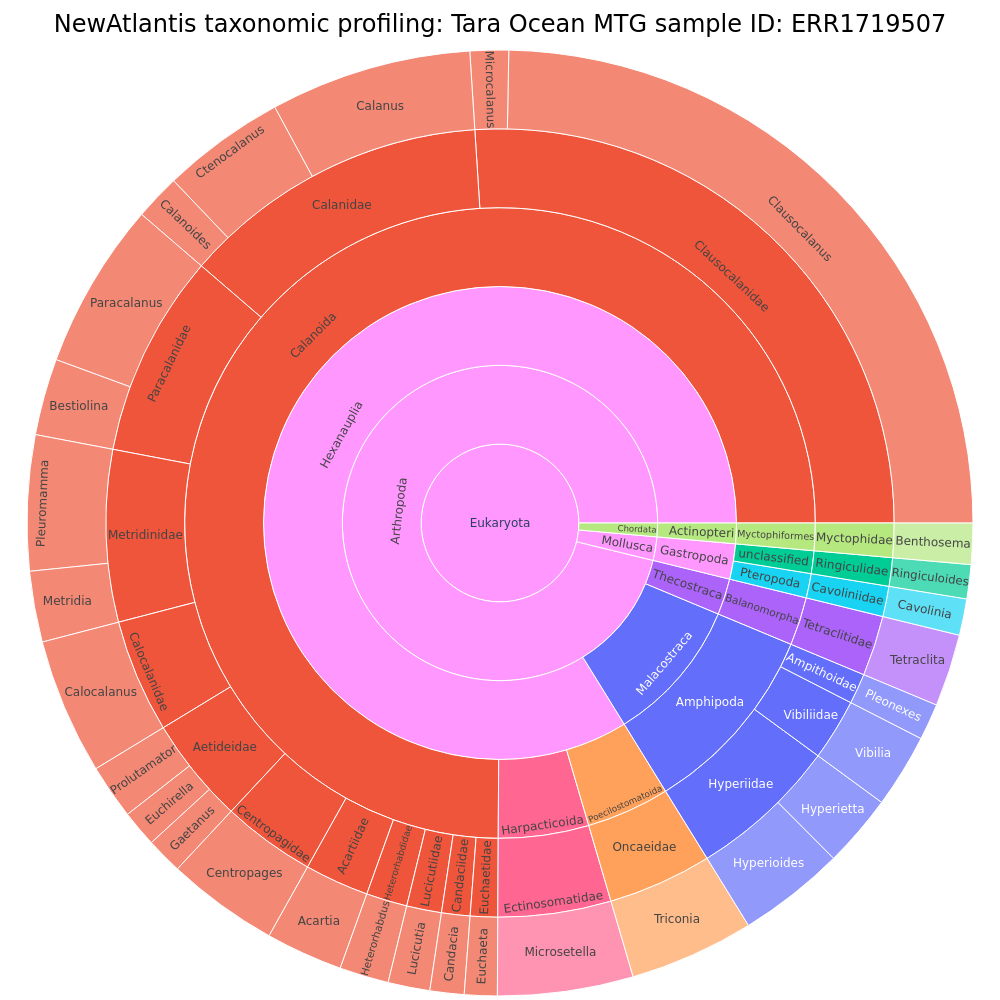

In [14]:
fig = px.sunburst(tax_enumeration_df_filtered,#.query('superkingdom == "Eukaryota"'), 
                  path=['superkingdom','phylum', 'class', 'order', 'family', 'genus'], 
                  values='log_abundance', color='order')

fig.update_layout(
                title={
                    'text': "NewAtlantis taxonomic profiling: Tara Ocean MTG sample ID: ERR1719507",
                    'y':0.985,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top',
                    'font_size':24,
                    'font_color':"black"})


# fig.update_yaxes(automargin=True)
# fig.update_xaxes(automargin=True)

fig.update_layout(
    autosize=False,
#     width=500,
#     height=500,
    margin=dict(
        l=1,
        r=1,
        b=4,
        t=50,
        pad=2
    ),
    paper_bgcolor="White",
)

fig.show(width=1000, height=1000 )
# pio.write_image(fig, "CustomProkEukDB/SunburstTaxDist_DB_v2.3.png", width=1.5*1000, height=1*1000, scale =1.25)

### Observations  

- Zooplankton is clearly the numerically dominant taxonomic group in this sample.
- Based on the test performed above, one can conclude that the taxonomic profiling tool (see description at the top of this notebook) is quite effective at profiling the taxonomic composition of MTG datasets using our **NewAtlantis** customized DB.  

- The tool is ready for large-scale testing (using more TARA Ocean MTG datasets) for better assessing the ability of the computational pipeline to characterize taxonomic diversity of samples collected across a great variety of oceanic provinces.  

- Once testing is achieved, we can confidently deploy the tool to characterize the **NewAtlantis** collected MTG datasets for the many MPAs we will be targeting in the near future.

### Expanding the community composition analysis of TARA's MTGs  

The following sunburst plot illustrates the diversity of taxonomic groups (e.g. families) found across numerous TARA Oceans MTG datasets

In [15]:
aggr_cleaned_concat_df = pd.read_csv('../../data/taxa_profiling_test_1/TARA_taxonomic_raw_counts.csv', index_col='Unnamed: 0').reset_index(drop=True)

In [16]:
aggr_cleaned_concat_df

,Family,Stations,Counts
0,Calocalanidae,Bermuda (MRGID:21979),19.0
1,Corycaeidae,Bermuda (MRGID:21979),33.0
2,Myctophidae,Bermuda (MRGID:21979),5.0
3,Pontellidae,Bermuda (MRGID:21979),6.0
4,Calocalanidae,Bermuda (MRGID:21979),78.0
...,...,...,...
89,Lucicutiidae,Marquesas (MRGID:21741),17.0
90,Mecynoceridae,Marquesas (MRGID:21741),35.0
91,Calocalanidae,Northern Galapagos Islands (MRGID:21871),12.0
92,Corycaeidae,Northern Galapagos Islands (MRGID:21871),9.0


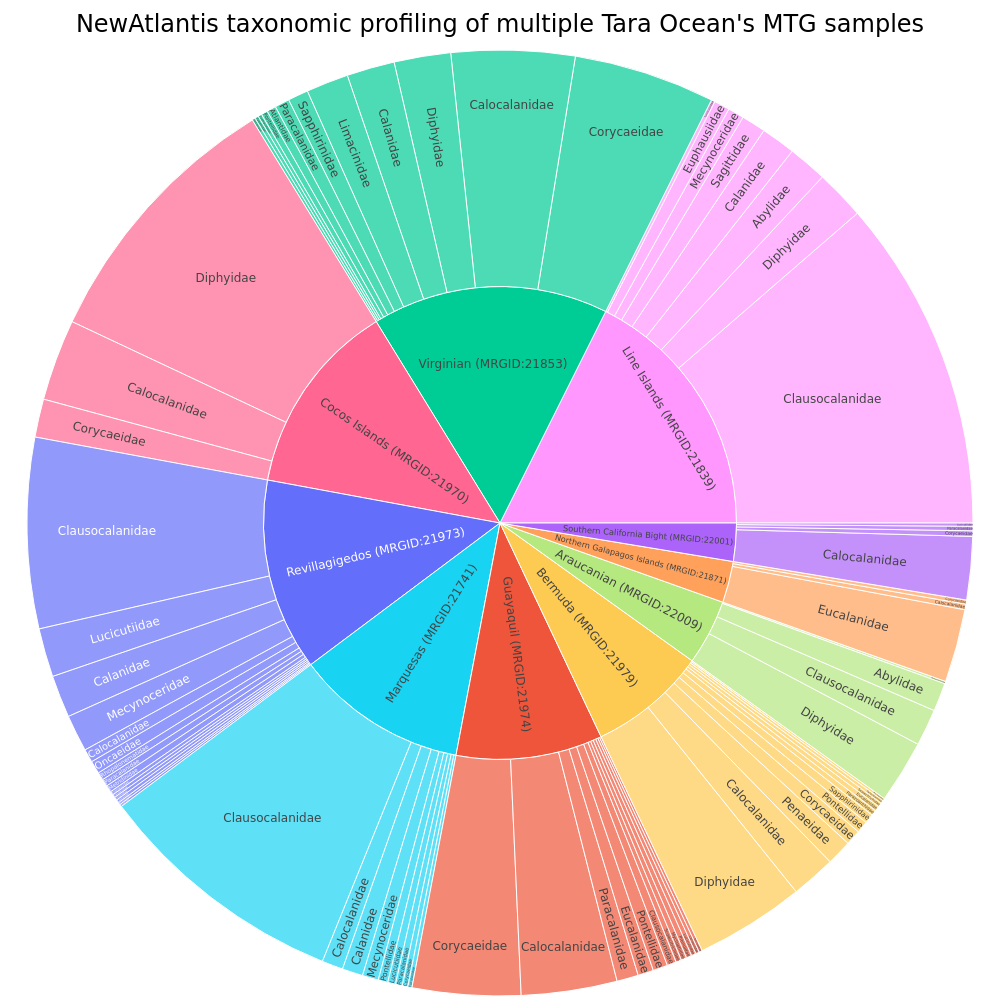

In [17]:
fig = px.sunburst(aggr_cleaned_concat_df, 
                  path=['Stations','Family'], 
                  values='Counts', color='Stations')

fig.update_layout(
                title={
                    'text': "NewAtlantis taxonomic profiling of multiple Tara Ocean's MTG samples",
                    'y':0.985,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top',
                    'font_size':24,
                    'font_color':"black"})


# fig.update_yaxes(automargin=True)
# fig.update_xaxes(automargin=True)

fig.update_layout(
    autosize=False,
#     width=500,
#     height=500,
    margin=dict(
        l=1,
        r=1,
        b=4,
        t=50,
        pad=2
    ),
    paper_bgcolor="White",
)

fig.show(width=1000, height=1000 )
# pio.write_image(fig, "PWY_Abund_Dist_Spectrum_TARA.png", #width=1.5*1000, height=1*1000, scale =1.25)

The following DF represents the whole set of MTGs considered as test cases

In [18]:
#Read in DF containing info on metaGs and metaTs
metag_df = pd.read_csv('../../data/taxa_profiling_test_1/TARA_metaG_metadata.tsv',index_col='Unnamed: 0')

#ID samples by SAM accession ID
accessions_list = metag_df['sample_accession'].drop_duplicates().values

Checking number of tasks run to completion 

In [19]:
get_all_output_files = glob.glob("../../results/taxa_profiling_test_1/SAMEA*_mapped_reads.map")

success_runs = []
for ofn in get_all_output_files:
    with open(ofn,'r') as fid:
        l = fid.readlines()[1:]
        if(len(l)>10):
            success_runs.append(ofn.split("_mapped_reads.map")[0].split('/')[-1])
            
#Samples to re-run for metaGs            
sid_samples2rerun = list(set(accessions_list).difference(set(success_runs)))

# print("Total No. of jobs still pending for running: {}\n".format(len(sid_samples2rerun)))

print("No. success runs: {}".format(len(success_runs)))

No. success runs: 50


#### Analyzing taxonomic abundance profiles

In [20]:
#Cast all the counts for all samples in a DF
dfs_cont = []
for sid in success_runs:

    with open("../../results/taxa_profiling_test_1/{}_mapped_reads.map".format(sid),'r') as fid:

        lines = fid.readlines()[1:]

        tax_cont = []
        count_cont = []
        for l in lines:
            tax, count = l.rstrip().split('\t')
            tax = tax.split('__')[-1]
            tax_cont.append(tax)
            count = float(count)
            count_cont.append(count)

        tax_counts_df = pd.DataFrame(data=count_cont,index=tax_cont,columns=[sid])
        dfs_cont.append(tax_counts_df)

#Fill NAN with 0
concat_dfs = pd.concat(dfs_cont).fillna(0)
#Get unique list of taxa identified
unique_idx_list = concat_dfs.index.drop_duplicates()
#Filtered by those that have a description down to at least species 
unique_idx_list = unique_idx_list[unique_idx_list.str.contains('_')]
#Do some extra cleaning here: filtering cases having ';' as separator, which is typical for taxonomic labels
unique_idx_list = [i for i in unique_idx_list if ';' in i]

In [21]:
#Do a bit of massaging here
concat_dfs = concat_dfs.loc[unique_idx_list].reset_index().groupby('index').sum()
#Filter rows
concat_dfs = concat_dfs.loc[concat_dfs.index.str.contains(';')]
#Sort columns by total counts
concat_dfs = concat_dfs[concat_dfs.sum().sort_values(ascending=False).index]

In [22]:
#Do some massaging here to get a properly formatted df
sorted_sid_dfs = []
for sid in concat_dfs.columns:
    sid_df = concat_dfs[sid].reset_index()
    sorted_sid_df = sid_df.sort_values(sid, ascending=False).drop_duplicates('index').set_index('index').loc[unique_idx_list]
    sorted_sid_dfs.append(sorted_sid_df)

In [23]:
# #Get a clean df with all the samples and unique idx/taxa
# cleaned_concat_dfs = pd.concat(sorted_sid_dfs, axis=1)
#Remove samples with relatively low summed counts
# cleaned_concat_dfs = cleaned_concat_dfs[cleaned_concat_dfs.columns[cleaned_concat_dfs.sum() > 50]]
cleaned_concat_dfs = concat_dfs[concat_dfs.columns[concat_dfs.sum()>50]]

In [24]:
#Now let's filter taxa by cutoff for max value observed across samples (>=10) & min number of observations (>=1) with min counts >= 3
unique_idx_list2 = cleaned_concat_dfs.index

filtered_taxa = []
for idx in unique_idx_list2:
    tax_profile = cleaned_concat_dfs.loc[idx]
    max_count = tax_profile.max()
    if(max_count>=5 & sum(tax_profile>=1)>=3):
        filtered_taxa.append(idx)
        
#Cast filtered data into a new df
new_cleaned_concat_df = cleaned_concat_dfs.loc[filtered_taxa]
new_cleaned_concat_df = new_cleaned_concat_df.loc[new_cleaned_concat_df.index[new_cleaned_concat_df.index.str.contains(';')]]
#Apply a simple log transformed with a pseudocount to prevent inf
# log_transf_cleaned_concat_df = (new_cleaned_concat_df + 1).applymap(np.log10)

In [25]:
#Running the python tool taxaranks: this is to extract the full lineage of each identified taxon

#First fetch highest taxonomic level
high_tax_lvls = new_cleaned_concat_df.index.map(lambda x: x.split(';')[-1]).map(lambda s: s.replace('_', ' ')).values
taxa_input = '../../data/taxa_profiling_test_1/taxa.input'
taxa_output = '../../data/taxa_profiling_test_1/taxa.output'
taxa_err = '../../data/taxa_profiling_test_1/taxa.err'

# with open(taxa_input,'w') as fid:
#     for ele in high_tax_lvls:
#         fid.write(ele + '\n')
        
###Run taxaranks to fetch tax lineages (call the executable directly)
###NOTE: make sure to pass the full path to the executable: taxaranks!
# !${SCRATCH_DATA}/envs/biobakery3/bin/taxaranks -i $taxa_input -o $taxa_output

#Read in df with tax lineages
tax_lineages = pd.read_csv(taxa_output,sep='\t').fillna('undefined')
# tax_lineages['user_taxa'] = tax_lineages['user_taxa'].map(lambda s: s.replace(' ','_'))
tax_lineages.drop_duplicates('user_taxa', inplace=True)
tax_lineages.set_index('user_taxa',inplace=True)

print("Total number of distinct taxonomic groups: {}".format(tax_lineages.shape[0]))

Total number of distinct taxonomic groups: 61


In [26]:
#Set a new df for plotting purposes
new_cleaned_concat_df2 = new_cleaned_concat_df.copy()
new_cleaned_concat_df2.index = new_cleaned_concat_df2.index.map(lambda s: s.split(';')[-1].replace('_', ' '))
new_cleaned_concat_df2 = new_cleaned_concat_df2.loc[tax_lineages.index]
#Set index to family level
new_cleaned_concat_df2.index = new_cleaned_concat_df2.index.map(tax_lineages['family'].to_dict())
#Group data by user_taxa to shape the df in a way that we can generate the stacked barplots
aggr_cleaned_concat_df = new_cleaned_concat_df2.reset_index().groupby('user_taxa').sum()
#Filter again by counts
aggr_cleaned_concat_df2 = aggr_cleaned_concat_df[aggr_cleaned_concat_df.columns[(aggr_cleaned_concat_df.sum() >= 30)]]
#Rename index
aggr_cleaned_concat_df2.index.name = 'Family'
#Drop rows labbeld 'undefined' 
aggr_cleaned_concat_df2 = aggr_cleaned_concat_df2.loc[~aggr_cleaned_concat_df2.index.str.contains('undefined')]

In [28]:
#DF of raw counts per family
aggr_cleaned_concat_df2

,SAMEA2731784,SAMEA2731641,SAMEA2657088,SAMEA2731788,SAMEA2732598,SAMEA2656986,SAMEA2732095,SAMEA2732932,SAMEA2732736,SAMEA2732214,...,SAMEA2732658,SAMEA2622393,SAMEA2657010,SAMEA2730869,SAMEA2657071,SAMEA2732790,SAMEA2732035,SAMEA2730873,SAMEA2657072,SAMEA2731851
Family,,,,,,,,,,,,,,,,,,,,,
Abylidae,85.0,2.000000,0.00,0.0,0.0,0.000000,0.0,0.0,2.000000,0.0,...,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
Aetideidae,0.0,0.000000,7.00,0.0,0.0,0.000000,0.0,0.0,2.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
Atlantidae,0.0,0.000000,20.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
Calanidae,75.0,92.000000,99.00,38.0,21.0,2.000000,21.0,0.0,0.000000,0.0,...,5.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,3.0,8.0
Calocalanidae,0.0,29.000000,223.00,1.0,232.0,167.000000,0.0,0.0,78.000000,0.0,...,45.0,8.0,16.0,0.0,19.0,41.0,30.0,3.0,2.0,0.0
Candaciidae,0.0,0.000000,0.00,0.0,0.0,8.000000,0.0,0.0,1.000000,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Centropagidae,3.0,5.000000,0.00,4.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cestidae,0.0,0.000000,4.00,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clausocalanidae,723.0,414.000000,0.00,520.0,0.0,0.000000,318.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,23.0,0.0,0.0,0.0,20.0,1.0,5.0
